# 1.Import packages

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# 2.Train a model using EMA

### 2.1.Get Historic Pricing Data
data is from finance.yahoo.com in form of a .csv file.

In [21]:
df = pd.read_csv('TSLA2022-2023.csv')
print(df)
print(df.describe())

           Date        Open        High         Low       Close   Adj Close  \
0    2022-01-19  347.236664  351.556671  331.666656  331.883331  331.883331   
1    2022-01-20  336.576660  347.220001  331.333344  332.089996  332.089996   
2    2022-01-21  332.113342  334.850006  313.500000  314.633331  314.633331   
3    2022-01-24  301.586670  311.170013  283.823334  310.000000  310.000000   
4    2022-01-25  304.733337  317.086670  301.070007  306.133331  306.133331   
..          ...         ...         ...         ...         ...         ...   
246  2023-01-11  122.089996  125.949997  120.510002  123.220001  123.220001   
247  2023-01-12  122.559998  124.129997  117.000000  123.559998  123.559998   
248  2023-01-13  116.550003  122.629997  115.599998  122.400002  122.400002   
249  2023-01-17  125.699997  131.699997  125.019997  131.490005  131.490005   
250  2023-01-18  136.559998  136.679993  127.010002  128.779999  128.779999   

        Volume  
0     75442500  
1     70488600  


### 2.2.Prepare the data
Before developing our regression model we are going to trim our data. The ‘Date’ column will be converted to a DatetimeIndex and the ‘Adj Close’ will be the only numerical values we keep. Everything else is getting dropped.

In [22]:
df.set_index(pd.to_datetime(df['Date']), inplace=True)
print(df[['Adj Close']])
print(df.info())


             Adj Close
Date                  
2022-01-19  331.883331
2022-01-20  332.089996
2022-01-21  314.633331
2022-01-24  310.000000
2022-01-25  306.133331
...                ...
2023-01-11  123.220001
2023-01-12  123.559998
2023-01-13  122.400002
2023-01-17  131.490005
2023-01-18  128.779999

[251 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-01-19 to 2023-01-18
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       251 non-null    float64
 2   High       251 non-null    float64
 3   Low        251 non-null    float64
 4   Close      251 non-null    float64
 5   Adj Close  251 non-null    float64
 6   Volume     251 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 15.7+ KB
None


we try to get a visual picture of our data

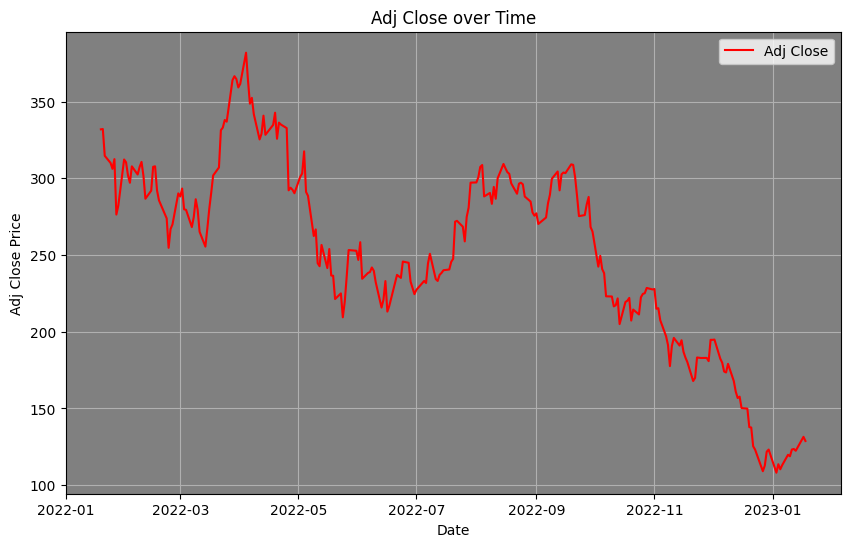

In [23]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df.index, df['Adj Close'], label='Adj Close', color='red')
plt.title('Adj Close over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('grey')
plt.show()

### 2.3.adding EMA
now we add add **exponential moving average (EMA)** to our data:

In [24]:
df['EMA_10'] = df['Adj Close'].ewm(span=10, adjust=False).mean()

### 2.4.drawing chart
let’s take a quick look at a plot of our data now to get an idea of how the EMA value tracks with the adjusted closing price.

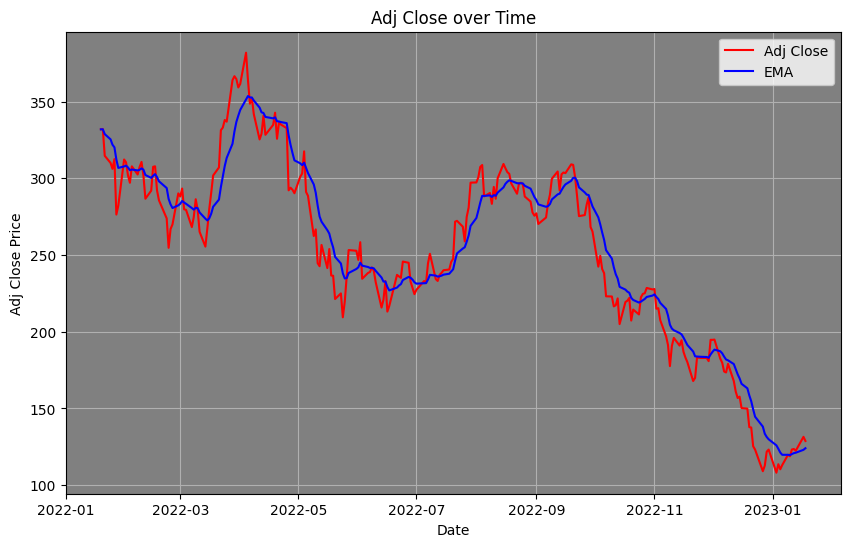

In [25]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df.index, df['Adj Close'], label='Adj Close', color='red')
plt.plot(df.index, df['EMA_10'], label='EMA', color='blue')
plt.title('Adj Close over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('grey')
plt.show()

### 2.5 Training the Model
Now we’re ready to start developing our regression model to see how effective the EMA is at predicting the price of the stock.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df[['EMA_10']], df[['Adj Close']], test_size=.2)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### 2.6.Validating the Fit

In [27]:
print("Model Coefficients:", model.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))

Model Coefficients: [[1.0312135]]
Mean Absolute Error: 14.015461364407054
Coefficient of Determination: 0.9199276232011313


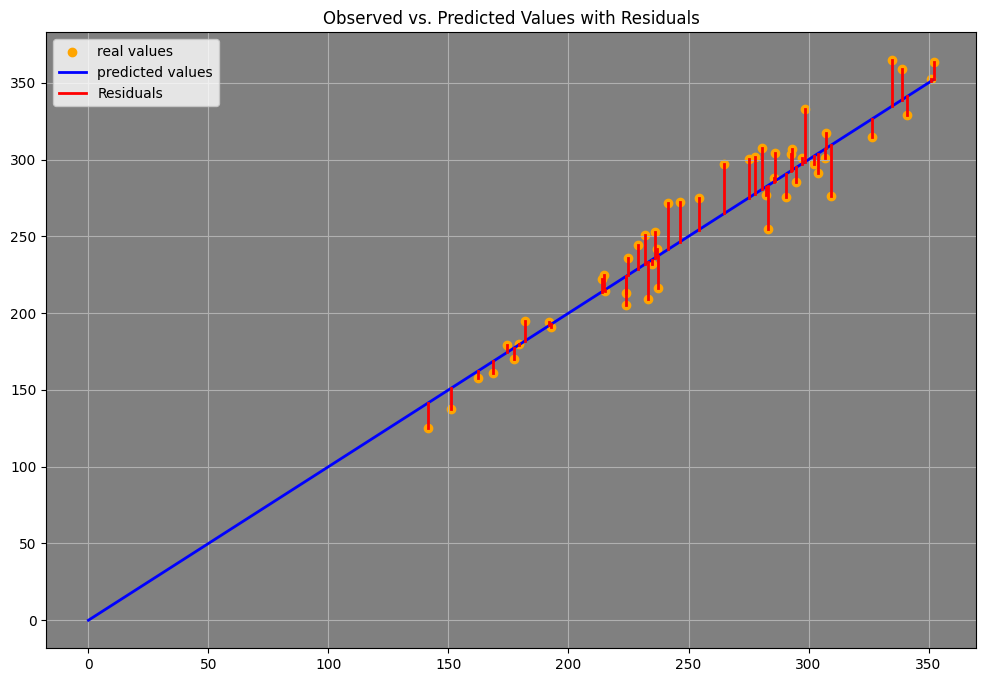

In [28]:
residuals = y_test - y_pred
plt.figure(figsize=(12, 8))
plt.scatter(y_pred, y_test, color='orange', marker='o', alpha=1, label='real values')
plt.plot([0, max(y_pred)[0]], [0, max(y_pred)[0]], color='blue', linestyle='-', linewidth=2, label='predicted values')
for i in range(len(residuals)):
    plt.plot([y_pred[i], y_pred[i]], [y_test.iloc[i], y_pred[i]], color='red', linestyle='-', linewidth=2, alpha=1)
plt.plot([0,0], [0,0], color='red', linestyle='-', linewidth=2, alpha=1, label='Residuals')
plt.title('Observed vs. Predicted Values with Residuals')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('grey')
plt.show()

In [29]:
df_test = pd.read_csv('TSLA2023-2024.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)
df_test['EMA_10'] = df_test['Adj Close'].ewm(span=10, adjust=False).mean()
budget = 10000
shares_held = 0
for index, row in df_test.iterrows():
    row  = row.to_frame().transpose()
    predicted_ema_10 = model.predict(row[['EMA_10']])[0][0]
    if predicted_ema_10 > row[['Open']].values[0][0] and budget > row[['Open']].values[0][0]:
        shares_bought = int(budget / row[['Open']].values[0][0])
        shares_held += shares_bought
        budget -= shares_bought * row[['Open']].values[0][0]
        budget += shares_held * row[['Close']].values[0][0]
        shares_held = 0
    df = pd.concat([df, row], ignore_index=True)
    df = df.drop(df.index[0])
    df.reset_index(drop=True, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(df[['EMA_10']], df[['Adj Close']], test_size=.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
print(f"Initial Budget: $10,000")
print(f"Final Budget after Simulation: ${budget:.2f}")

Initial Budget: $10,000
Final Budget after Simulation: $14897.01


# 3.train a model using RSI
### 3.1.Get Historic Pricing Data

In [30]:
df = pd.read_csv('TSLA2022-2023.csv')
print(df)
print(df.describe())

           Date        Open        High         Low       Close   Adj Close  \
0    2022-01-19  347.236664  351.556671  331.666656  331.883331  331.883331   
1    2022-01-20  336.576660  347.220001  331.333344  332.089996  332.089996   
2    2022-01-21  332.113342  334.850006  313.500000  314.633331  314.633331   
3    2022-01-24  301.586670  311.170013  283.823334  310.000000  310.000000   
4    2022-01-25  304.733337  317.086670  301.070007  306.133331  306.133331   
..          ...         ...         ...         ...         ...         ...   
246  2023-01-11  122.089996  125.949997  120.510002  123.220001  123.220001   
247  2023-01-12  122.559998  124.129997  117.000000  123.559998  123.559998   
248  2023-01-13  116.550003  122.629997  115.599998  122.400002  122.400002   
249  2023-01-17  125.699997  131.699997  125.019997  131.490005  131.490005   
250  2023-01-18  136.559998  136.679993  127.010002  128.779999  128.779999   

        Volume  
0     75442500  
1     70488600  


### 3.2.Prepare the data
Before developing our regression model we are going to trim our data. The ‘Date’ column will be converted to a DatetimeIndex and the ‘Adj Close’ will be the only numerical values we keep. Everything else is getting dropped.

In [31]:
df.set_index(pd.to_datetime(df['Date']), inplace=True)
print(df[['Adj Close']])
print(df.info())

             Adj Close
Date                  
2022-01-19  331.883331
2022-01-20  332.089996
2022-01-21  314.633331
2022-01-24  310.000000
2022-01-25  306.133331
...                ...
2023-01-11  123.220001
2023-01-12  123.559998
2023-01-13  122.400002
2023-01-17  131.490005
2023-01-18  128.779999

[251 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2022-01-19 to 2023-01-18
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       251 non-null    float64
 2   High       251 non-null    float64
 3   Low        251 non-null    float64
 4   Close      251 non-null    float64
 5   Adj Close  251 non-null    float64
 6   Volume     251 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 15.7+ KB
None


we try to get a visual picture of our data

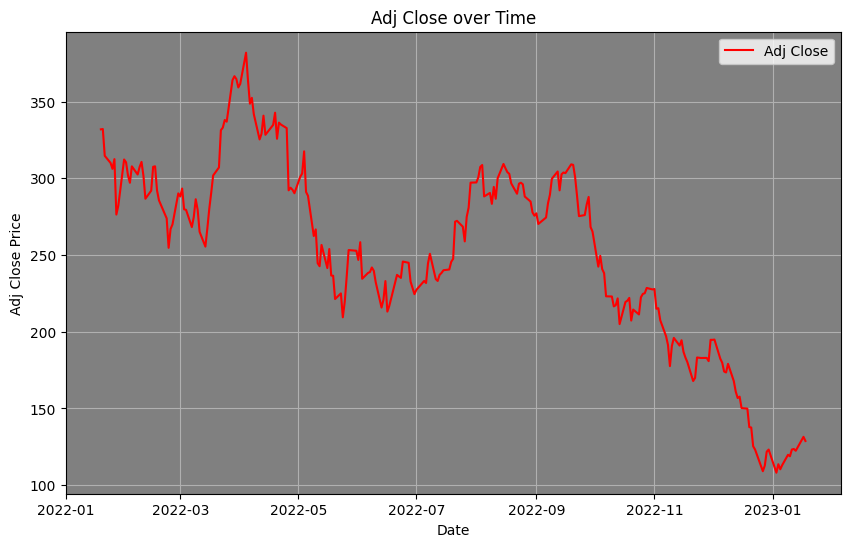

In [32]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df.index, df['Adj Close'], label='Adj Close', color='red')
plt.title('Adj Close over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('grey')
plt.show()

### 3.3.adding RSI
now we add **Relative Strength Index(RSI)** to our data:

In [33]:
df['Price Change'] = df['Close'].diff()
window = 14
df['Gain'] = np.where(df['Price Change'] > 0, df['Price Change'], 0)
df['Loss'] = np.where(df['Price Change'] < 0, -df['Price Change'], 0)
average_gain = df['Gain'].rolling(window=window, min_periods=1).mean()
average_loss = df['Loss'].rolling(window=window, min_periods=1).mean()
relative_strength = average_gain / average_loss
rsi = 100 - (100 / (1 + relative_strength))
df['RSI'] = rsi
df = df.drop(['Price Change', 'Gain', 'Loss'], axis=1)
df = df.drop(df.index[0])
df.reset_index(drop=True, inplace=True)

### 3.4.drawing chart
let’s take a quick look at a plot of our data now to get an idea of how the EMA value tracks with the adjusted closing price.

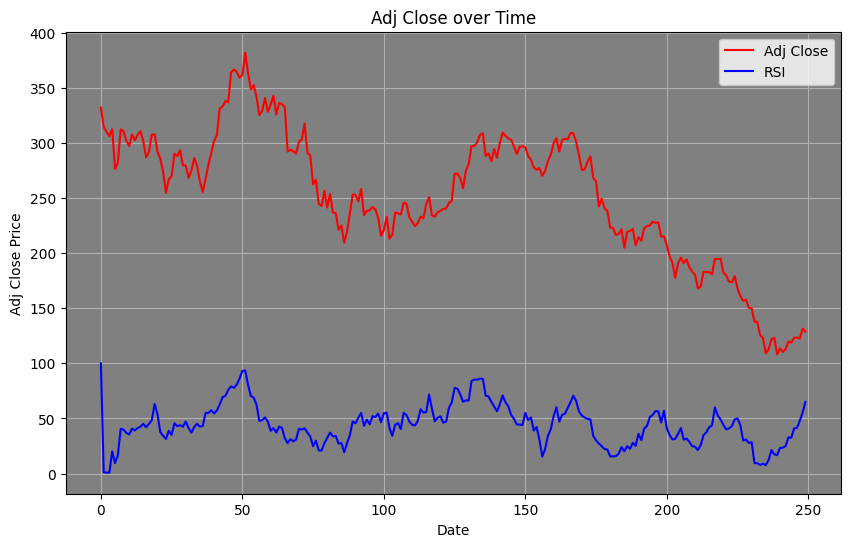

In [34]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df.index, df['Adj Close'], label='Adj Close', color='red')
plt.plot(df.index, df['RSI'], label='RSI', color='blue')
plt.title('Adj Close over Time')
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('grey')
plt.show()

### 3.5 Training the Model
Now we’re ready to start developing our regression model to see how effective the EMA is at predicting the price of the stock.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df[['RSI']], df[['Adj Close']], test_size=.2)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### 3.6.Validating the Fit

In [36]:
print("Model Coefficients:", model.coef_)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Coefficient of Determination:", r2_score(y_test, y_pred))

Model Coefficients: [[1.66357501]]
Mean Absolute Error: 39.632094426008656
Coefficient of Determination: 0.2187395618726663


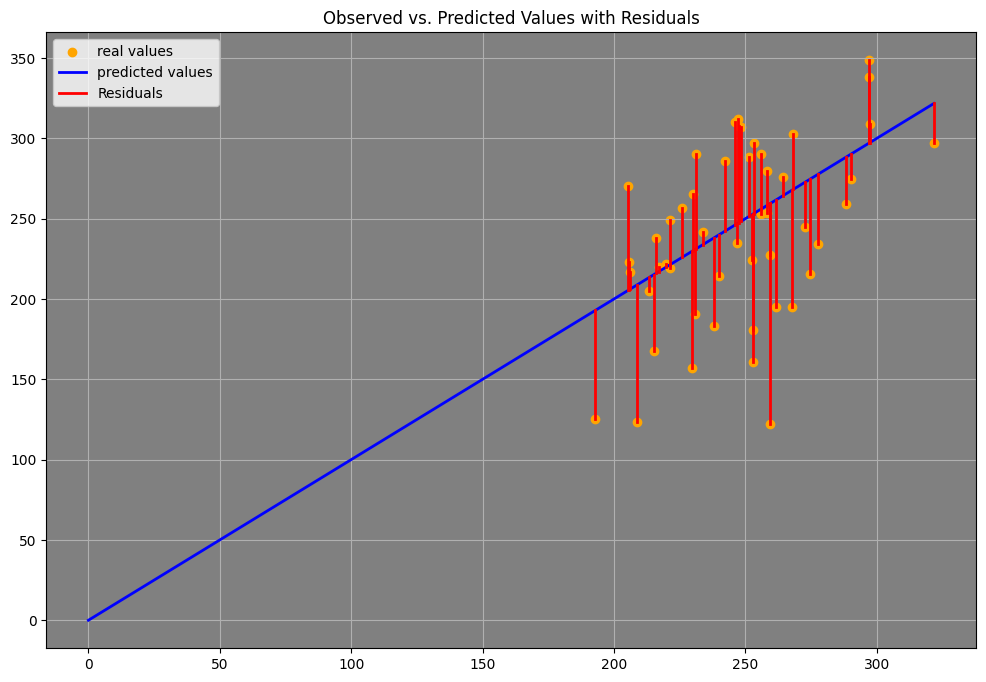

In [37]:
residuals = y_test - y_pred
plt.figure(figsize=(12, 8))
plt.scatter(y_pred, y_test, color='orange', marker='o', alpha=1, label='real values')
plt.plot([0, max(y_pred)[0]], [0, max(y_pred)[0]], color='blue', linestyle='-', linewidth=2, label='predicted values')
for i in range(len(residuals)):
    plt.plot([y_pred[i], y_pred[i]], [y_test.iloc[i], y_pred[i]], color='red', linestyle='-', linewidth=2, alpha=1)
plt.plot([0,0], [0,0], color='red', linestyle='-', linewidth=2, alpha=1, label='Residuals')
plt.title('Observed vs. Predicted Values with Residuals')
plt.legend()
plt.grid(True)
plt.gca().set_facecolor('grey')
plt.show()

In [38]:
df_test = pd.read_csv('TSLA2023-2024.csv')
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test.set_index('Date', inplace=True)
df_test['Price Change'] = df_test['Close'].diff()
window = 14
df_test['Gain'] = np.where(df_test['Price Change'] > 0, df_test['Price Change'], 0)
df_test['Loss'] = np.where(df_test['Price Change'] < 0, -df_test['Price Change'], 0)
average_gain = df_test['Gain'].rolling(window=window, min_periods=1).mean()
average_loss = df_test['Loss'].rolling(window=window, min_periods=1).mean()
relative_strength = average_gain / average_loss
rsi = 100 - (100 / (1 + relative_strength))
df_test['RSI'] = rsi
df_test = df_test.drop(['Price Change', 'Gain', 'Loss'], axis=1)
df_test = df_test.drop(df_test.index[0])
df_test.reset_index(drop=True, inplace=True)
budget = 10000
shares_held = 0
for index, row in df_test.iterrows():
    row  = row.to_frame().transpose()
    predicted_ema_10 = model.predict(row[['RSI']])[0][0]
    if predicted_ema_10 > row[['Open']].values[0][0] and budget > row[['Open']].values[0][0]:
        shares_bought = int(budget / row[['Open']].values[0][0])
        shares_held += shares_bought
        budget -= shares_bought * row[['Open']].values[0][0]
        budget += shares_held * row[['Close']].values[0][0]
        shares_held = 0
    df = pd.concat([df, row], ignore_index=True)
    df = df.drop(df.index[0])
    df.reset_index(drop=True, inplace=True)
    X_train, X_test, y_train, y_test = train_test_split(df[['RSI']], df[['Adj Close']], test_size=.2)
    model = LinearRegression()
    model.fit(X_train, y_train)
print(f"Initial Budget: $10,000")
print(f"Final Budget after Simulation: ${budget:.2f}")

Initial Budget: $10,000
Final Budget after Simulation: $16612.39
